# Codes for Evaluating the Faster R-CNN Model performance on the test data
The evaluations in this notebook were run on Jarret's M1 Max MacBook Pro. 

## Initial imports and constants

All imports

In [1]:
import os

# Torch imports
import torch
from torchvision.ops import boxes as box_ops
from torch.utils.data import DataLoader

from tqdm import tqdm_notebook as tqdm

# For saving the predictions and labels
import pickle

# Imports from local packages
from src.model import create_model
from src.config import *
from src.utils import Averager, collate_fn, get_transform
from src.PolypDataset import PolypDataset

# Ignore warnings about TQDM....
import warnings
warnings.filterwarnings("ignore")

# Define constants
iou_threshold = 0.5
num_classes = 2  # Change to the number of classes in your dataset
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [2]:
# Auo reload modules
%load_ext autoreload
%autoreload 2

## Load in the test data and instantiate the DataLoader

In [13]:
# Define the test data directory
test_data_directory = os.path.join(os.getcwd(), 'data', 'test')

# Load the test dataset
test_dataset = PolypDataset(
    dir_path = TEST_DIR,
    width = RESIZE_TO,
    height = RESIZE_TO,
    classes = CLASSES,
    transforms = get_transform(train=False)
)

test_dataloader = DataLoader(
    dataset=test_dataset, 
    batch_size=1, 
    shuffle=False, 
    num_workers=4 if torch.cuda.is_available() else 2,
    pin_memory=True,
    drop_last=False,
    collate_fn=collate_fn
)

## Instantiate the model and load the weights

In [3]:
model_weights = os.path.join('weights', 'model.pth')
model = create_model(num_classes=NUM_CLASSES)
model.load_state_dict(torch.load(model_weights, map_location=device))
model.to(device)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [22]:
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from src.utils import get_transform
img = imread(os.path.join('data', 'Original', '1.tif'))
img = resize(img, (RESIZE_TO, RESIZE_TO))
img = img.astype('float32') / 255.0
trans = get_transform(train=False)
sample = trans(
    image = img, 
    labels = [[]],
    bboxes = [[0, 0, 1, 1]])
image = sample['image']
image = torch.as_tensor(image, dtype=torch.float32)
pred = model([image.to(device)])


In [23]:
pred

[{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>)}]

## Predicting on the test set

### Function to save predictions and labels as pickle files

In [15]:
def save_outputs(predictions, labels, folder_path):
    """
    Pickles the predictions and labels objects and saves them to the given folder path.
    
    Args:
    predictions (list): list of tensors containing model predictions.
    labels (list): list of dictionaries containing corresponding labels.
    folder_path (str): path to the folder where the pickled files will be saved.
    """
    # Create folder if it doesn't exist
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # Pickle objects and save to files
    with open(os.path.join(folder_path, "predictions.pkl"), "wb") as f:
        pickle.dump(predictions, f)
    with open(os.path.join(folder_path, "labels.pkl"), "wb") as f:
        pickle.dump(labels, f)


### Run through the test data and get predictions for each image.

In [16]:
all_predictions = []
all_labels = []

with tqdm(test_dataloader) as pbar:
    for image, label in pbar:
        image = list(im.to(device) for im in image)
        label = [{k: v.to(device) for k, v in t.items()} for t in label]
        with torch.no_grad():
            prediction = model(image)
        all_predictions.append(prediction)
        all_labels.append(label)


  0%|          | 0/5 [00:00<?, ?it/s]

### Save the predictions and labels to a pickle file

In [17]:
predictions_dir = os.path.join(os.getcwd(), 'predictions-tiny')
save_outputs(all_predictions, all_labels, predictions_dir)

## Calculating the metrics from the predictions 

### Calculate the intersection over union (IoU) of two sets of boxes.

It might be more efficient to push the labels and predictions into numpy arrays in order to speed up the calculations. (look at `src/model_evaluation.py` for an example of how to calculate over two sets of boxes)

The bbox format needs to be examined to make this work. 

## Start here if labels are already saved

In [3]:
def load_outputs(folder_path):
    """
    Loads the pickled predictions and labels objects from the given folder path.
    
    Args:
    folder_path (str): path to the folder where the pickled files are saved.
    
    Returns:
    predictions (list): list of tensors containing model predictions.
    labels (list): list of dictionaries containing corresponding labels.
    """
    # Load pickled objects
    with open(os.path.join(folder_path, "predictions.pkl"), "rb") as f:
        predictions = pickle.load(f)
    with open(os.path.join(folder_path, "labels.pkl"), "rb") as f:
        labels = pickle.load(f)
    
    return predictions, labels

In [28]:
predictions_dir = os.path.join(os.getcwd(), 'predictions')
all_predictions, all_labels = load_outputs(predictions_dir)

In [21]:
def bbox_iou(box1, box2):
    """Calculate IoU between two bounding boxes"""
    box1_area = box_ops.box_area(box1)
    box2_area = box_ops.box_area(box2)
    iou = box_ops.box_iou(box1, box2)
    return iou

In [29]:
all_ious = []
with tqdm(zip(all_predictions, all_labels), total=len(all_predictions)) as pbar:
    for predictions, labels in pbar:
        for prediction, label in zip(predictions, labels):
            predicted_boxes = prediction['boxes']
            predicted_scores = prediction['scores']
            predicted_labels = prediction['labels']
            true_boxes = label['boxes']
            true_labels = label['labels']
            iou_for_image = []
            correct_box_predictions =[]
            for box_idx, true_box in enumerate(true_boxes):
                true_label = true_labels[box_idx]
                if true_label == 0:  # Skip the background class
                    continue
                max_iou = 0
                # Populate correct_box_predictions with the predicted boxes that have the same label as the true box
                for pred_box_idx, predicted_box in enumerate(predicted_boxes):
                    predicted_label = predicted_labels[pred_box_idx]
                    if predicted_label == true_label:
                        correct_box_predictions.append(true_box)
                        iou = bbox_iou(true_box[None, :], predicted_box[None, :])
                        if iou > max_iou:
                            max_iou = iou
                iou_for_image.append(max_iou)
            all_ious.append(iou_for_image)


  0%|          | 0/4872 [00:00<?, ?it/s]

### Calcluate the Recall, Precision, F1 Score for a given IoU threshold

In [61]:
def calculate_metrics(iou, threshold):
    """Calculate recall, precision, and f1 score for a given IoU threshold"""
    tp = (iou >= threshold).sum().item()
    fp = (iou < threshold).sum().item()
    fn = (iou <= threshold).sum().item()
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    return recall, precision, f1

average_recalls = []
average_precisions = []
average_f1s = []
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

recalls = []
precisions = []
f1s = []

for threshold in thresholds:
    total_recall = 0
    total_precision = 0
    total_f1 = 0
    for ious in all_ious:
        if len(ious) > 0:
            iou = torch.Tensor(ious).to(device)
            recall, precision, f1 = calculate_metrics(iou, threshold)
            recalls.append(recall)
            precisions.append(precision)
            f1s.append(f1)
            total_recall += recall
            total_precision += precision
            total_f1 += f1
    num_images_with_boxes = len([ious for ious in all_ious if len(ious) > 0])

    average_recall = total_recall / num_images_with_boxes if num_images_with_boxes else 0
    average_precision = total_precision / len(all_ious)
    average_f1 = total_f1 / len(all_ious)

    average_recalls.append(average_recall)
    average_precisions.append(average_precision)
    average_f1s.append(average_f1)



<AxesSubplot: ylabel='Thresholds'>

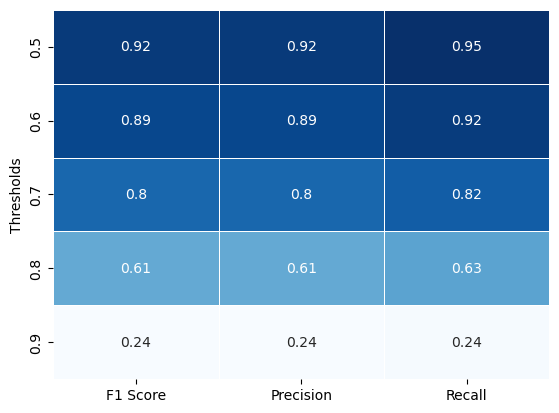

In [44]:
import seaborn as sns
import pandas as pd

# create a pandas dataframe to store the data
data = {'Thresholds': thresholds, 'Recall': average_recalls, 'Precision': average_precisions, 'F1 Score': average_f1s}
df = pd.DataFrame(data)

# create a pivot table to rearrange the data for plot
pivot = pd.pivot_table(df, index=['Thresholds'])

# plot the table using seaborn's heatmap function
sns.heatmap(pivot, annot=True, cmap='Blues', linewidths=0.5, cbar=False)


# The plots below are probably wrong, I am not great with visualizations. Moving on to other parts of the project for now. 

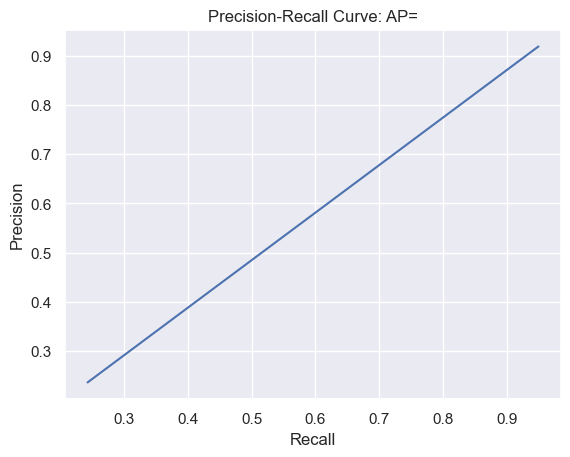

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import numpy as np

# define IoUs and labels
# IoUs = np.array(all_ious)
# labels = np.array([label[0]['labels'][0].to(int) for label in all_labels])

# compute precision and recall for different thresholds
# precision, recall, thresholds = precision_recall_curve(labels, IoUs)
# average_precision = average_precision_score(labels, IoUs)


# plot precision-recall curve
sns.set(style="darkgrid")
sns.lineplot(x=average_recalls, y=average_precisions)
plt.title('Precision-Recall Curve: AP=')#{0:0.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


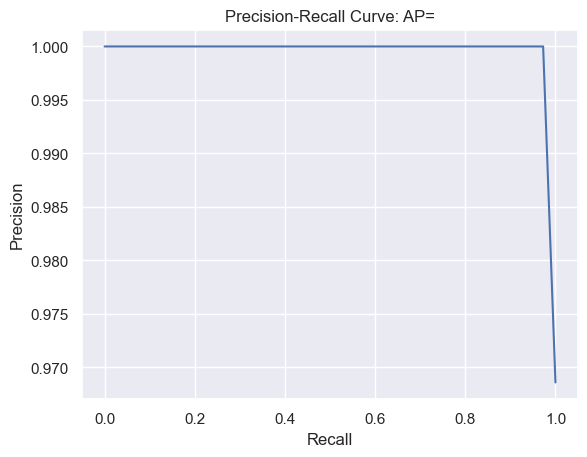

In [114]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import torchmetrics

for iou in all_ious:
    if len(iou) < 1:
        iou.append(0)

# define IoUs and labels
IoUs = torch.tensor([iou for ious in all_ious for iou in ious], dtype=torch.float)
labels = torch.tensor([label[0]['labels'][0] for label in all_labels], dtype=torch.int)

# create precision-recall curve object
pr_curve = torchmetrics.PrecisionRecallCurve(num_classes=1, pos_label=1, task='binary', thresholds=thresholds)
pr_curve.attach()
# update with IoUs and labels
pr_curve.update(torch.tensor(IoUs), torch.tensor(labels))

# retrieve precision, recall, thresholds
precision, recall, thresholds = pr_curve.compute()
# average_precision = pr_curve.compute()

# plot precision-recall curve
sns.set(style="darkgrid")
sns.lineplot(x=recall, y=precision)
plt.title('Precision-Recall Curve: AP=')#{0:0.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


In [111]:
precision.shape

torch.Size([4588])

In [112]:
recall.shape

torch.Size([4588])

In [115]:
thresholds

tensor([0.0000e+00, 3.2074e-04, 8.7697e-04,  ..., 9.8804e-01, 9.9129e-01,
        9.9259e-01])

In [93]:
all_ious

[[tensor([[0.6471]])],
 [tensor([[0.8736]])],
 [tensor([[0.9098]])],
 [tensor([[0.6409]])],
 [tensor([[0.7256]])],
 [tensor([[0.8178]])],
 [tensor([[0.6632]])],
 [tensor([[0.7144]])],
 [tensor([[0.7406]])],
 [tensor([[0.6589]])],
 [tensor([[0.9309]])],
 [tensor([[0.8365]])],
 [tensor([[0.8929]])],
 [tensor([[0.8720]])],
 [tensor([[0.7684]])],
 [tensor([[0.7174]])],
 [tensor([[0.7482]])],
 [tensor([[0.8521]])],
 [tensor([[0.6905]])],
 [tensor([[0.8776]])],
 [tensor([[0.7688]])],
 [tensor([[0.8389]])],
 [tensor([[0.9194]])],
 [tensor([[0.9048]])],
 [tensor([[0.6699]])],
 [tensor([[0.7570]])],
 [tensor([[0.7601]])],
 [tensor([[0.8575]])],
 [tensor([[0.7890]])],
 [tensor([[0.8682]])],
 [tensor([[0.7303]])],
 [tensor([[0.7100]])],
 [tensor([[0.6873]])],
 [tensor([[0.6803]])],
 [tensor([[0.7986]])],
 [tensor([[0.6755]])],
 [tensor([[0.7264]])],
 [tensor([[0.7625]])],
 [tensor([[0.7733]])],
 [tensor([[0.8090]])],
 [tensor([[0.8323]])],
 [tensor([[0.8270]])],
 [tensor([[0.7583]])],
 [tensor([[